# Preliminary Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [2]:
pd.set_option('display.max_rows',100)

# Importing Data

Dataset for socially rented dwelling by Local Authority, 1992-2021

In [3]:
df1 = pd.read_excel('Socially Rented Dwellings by LA, 1992-2021.xlsx')
df1.rename(columns={'new_dwellings':'SR'}, inplace=True)
df1.drop(columns='Unnamed: 0',inplace=True)
print(df1.shape)
df1.head()

(12000, 4)


,LA_code,LA,year,SR
0,E07000157,Alnwick,1992,44.0
1,E07000158,Berwick-upon-Tweed,1992,5.0
2,E07000159,Blyth Valley,1992,16.0
3,E07000160,Castle Morpeth,1992,8.0
4,E07000054,Chester-le-Street,1992,0.0


Dataset for total number of affordable dwellings by LA, 1992-2021

In [4]:
df2 = pd.read_excel('Total Affordable Rent Dwellings by LA, 1992-2021.xlsx')
df2.drop(columns='Unnamed: 0', inplace=True)
df2.rename(columns={'new_dwellings':'AR'}, inplace=True)
print(df2.shape)
df2.head()

(12000, 4)


,LA_code,LA,year,AR
0,E07000157,Alnwick,1992,45.0
1,E07000158,Berwick-upon-Tweed,1992,5.0
2,E07000159,Blyth Valley,1992,21.0
3,E07000160,Castle Morpeth,1992,8.0
4,E07000054,Chester-le-Street,1992,16.0


Total number of dwellings completed by Local Authority, 1980-2021

In [5]:
df3 = pd.read_excel('Dwellings by LA 1980-2021.xlsx')
df3.drop(columns=['Unnamed: 0','DLUHC Code','Former ONS Code'], inplace=True)
df3 = df3[['ONS Code','Local Authority','DC_Total','year']][df3.loc[:,'year']>=1992]
df3.reset_index(drop=True,inplace=True)
df3.rename(columns={'ONS Code':'LA_code','Local Authority':'LA'},inplace=True)

In [6]:
df3[df3.loc[:,'LA']=='Coventry']

,LA_code,LA,DC_Total,year
344,E08000026,Coventry,230,1992
711,E08000026,Coventry,390,1993
1078,E08000026,Coventry,330,1994
1445,E08000026,Coventry,490,1995
1811,E08000026,Coventry,530,1996
2169,E08000026,Coventry,460,1997
2527,E08000026,Coventry,410,1998
2698,E08000026,Coventry,570,1999
3052,E08000026,Coventry,510,2000
3406,E08000026,Coventry,340,2001


Importing data for median house price in UK by Local Authority, 1995-2021

In [7]:
df4 = pd.read_excel('Median House Prices by LA 1995-2021, Quarterly, Long.xlsx')


In [8]:
df4['quarter'] = df4['quarter'].map(lambda x: ''.join(x.split()))

In [9]:
df4 = df4.loc[df4.quarter!='...109',:]

In [10]:
df4['date'] = pd.to_datetime(df4['quarter'],format='%b%Y')

Merging all datasets into one

In [11]:
df = pd.merge(df1,df2,on=['LA_code','LA','year'])
df = pd.merge(df,df3,on=['LA_code','LA','year'])
df.loc[:,'date'] = pd.to_datetime(df.loc[:,'year'].astype(str),format='%Y')
df.loc[df.DC_Total=='..','DC_Total'] = np.nan
df.loc[:,'DC_Total'] = df.loc[:,'DC_Total'].astype(float)

In [12]:
df.head()

,LA_code,LA,year,SR,AR,DC_Total,date
0,E07000157,Alnwick,1992,44.0,45.0,140.0,1992-01-01
1,E07000158,Berwick-upon-Tweed,1992,5.0,5.0,70.0,1992-01-01
2,E07000159,Blyth Valley,1992,16.0,21.0,410.0,1992-01-01
3,E07000160,Castle Morpeth,1992,8.0,8.0,140.0,1992-01-01
4,E07000054,Chester-le-Street,1992,0.0,16.0,340.0,1992-01-01


Extracting data for Coventry alone

In [13]:
dcov = df[df.loc[:,'LA']=='Coventry'].copy()
dcov.head()

,LA_code,LA,year,SR,AR,DC_Total,date
109,E08000026,Coventry,1992,102.0,127.0,230.0,1992-01-01
408,E08000026,Coventry,1993,231.0,331.0,390.0,1993-01-01
707,E08000026,Coventry,1994,378.0,474.0,330.0,1994-01-01
1006,E08000026,Coventry,1995,271.0,371.0,490.0,1995-01-01
1305,E08000026,Coventry,1996,203.0,315.0,530.0,1996-01-01


In [14]:
dcov.reset_index(drop=True,inplace=True)

Filling in some missing values using external data and interpolation

In [15]:
dcov.loc[13,'DC_Total'] = 140

In [16]:
dcov['DC_Total'] = dcov['DC_Total'].interpolate()

In [17]:
dcov['SR_p'] = (dcov['SR']/dcov['AR'])*100
dcov['AR_p'] = (dcov['AR']/dcov['DC_Total'])*100
dcov

,LA_code,LA,year,SR,AR,DC_Total,date,SR_p,AR_p
0,E08000026,Coventry,1992,102.0,127.0,230.0,1992-01-01,80.314961,55.217391
1,E08000026,Coventry,1993,231.0,331.0,390.0,1993-01-01,69.788520,84.871795
2,E08000026,Coventry,1994,378.0,474.0,330.0,1994-01-01,79.746835,143.636364
3,E08000026,Coventry,1995,271.0,371.0,490.0,1995-01-01,73.045822,75.714286
4,E08000026,Coventry,1996,203.0,315.0,530.0,1996-01-01,64.444444,59.433962
5,E08000026,Coventry,1997,86.0,163.0,460.0,1997-01-01,52.760736,35.434783
6,E08000026,Coventry,1998,127.0,211.0,410.0,1998-01-01,60.189573,51.463415
7,E08000026,Coventry,1999,193.0,227.0,570.0,1999-01-01,85.022026,39.824561
8,E08000026,Coventry,2000,190.0,204.0,510.0,2000-01-01,93.137255,40.000000
9,E08000026,Coventry,2001,99.0,100.0,340.0,2001-01-01,99.000000,29.411765


In [52]:
dpop = pd.read_excel('Population by LA, 2001-2020.xlsx')
dpop.drop(columns=['Unnamed: 0'],inplace=True)
dpop.head()

,LA_code,LA,year,population,date
0,E06000001,Hartlepool,2001,90152,2001-01-01
1,E06000002,Middlesbrough,2001,141233,2001-01-01
2,E06000003,Redcar and Cleveland,2001,139159,2001-01-01
3,E06000004,Stockton-on-Tees,2001,183795,2001-01-01
4,E06000005,Darlington,2001,97894,2001-01-01


In [54]:
dcov_pop = dpop[dpop.loc[:,'LA']=='Coventry'].copy()
dcov_pop.reset_index(drop=True,inplace=True)
dcov_pop.head()

,LA_code,LA,year,population,date
0,E08000026,Coventry,2001,302804,2001-01-01
1,E08000026,Coventry,2002,301295,2002-01-01
2,E08000026,Coventry,2003,300665,2003-01-01
3,E08000026,Coventry,2004,298174,2004-01-01
4,E08000026,Coventry,2005,298386,2005-01-01


In [ ]:
for x in dcov_pop.index[1:]:
    dcov_pop.loc[x,'pchange'] = dcov_pop.loc[x,'population'] - dcov_pop.loc[x-1,'population']

dcov_pop.head()

# Visualisation

Plotting socially rented and affordable dwellings against total housing in Coventry, red line denotes housing need as assessed in Local Plan 2017 Housing SPD.

C:\Users\adnaa\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


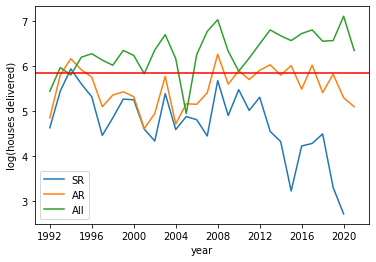

In [18]:
x = dcov['date']
y1 = np.log(dcov['SR'])
y2 = np.log(dcov['AR'])
y3 = np.log(dcov['DC_Total'])
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.axhline(y=np.log(348),color='r')
plt.xlabel('year')
plt.ylabel('log(houses delivered)')
plt.legend(['SR','AR','All'])

Note the fall in affordable housing since 2018, caused by?

In [33]:
dt = df[['LA_code','LA','SR','AR','DC_Total','date']].groupby(['date']).mean()
# what about missing values?

In [45]:
dt['AR_p'] = dt['AR']/dt['DC_Total']*100

In [48]:
x = dt.index
y1 = dt['SR']
y2 = dt['AR_p']
y3 = dcov['SR']
y4 = dcov['AR_p']

Text(0.5, 1.0, 'Coventry Affordable Home Delivery v. National Average')

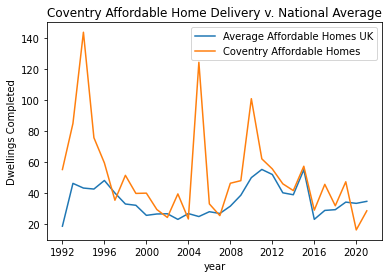

In [50]:
#plt.plot(x,y1)
plt.plot(x,y2)
#plt.plot(x,y3)
plt.plot(x,y4)
plt.legend(['Average Affordable Homes UK','Coventry Affordable Homes'])
plt.xlabel('year')
plt.ylabel('Dwellings Completed')
plt.title('Coventry Affordable Home Delivery v. National Average')


Coventry is above the mean for affordable house delivery, but does not follow the recent trend of increasing affordable homes delivery.

Looking at relationship between house prices and housing supply. We compare changes in the median house price in Coventry with annual delivery of homes

In [66]:
dcov4 = df4[df4.loc[:,'LA']=='Coventry'].copy()
dcov4.reset_index(drop=True,inplace=True)
dcov4['year'] = dcov4['date'].dt.year

In [67]:
for x in dcov4.index[1:]:
    dcov4.loc[x,'price_change'] = dcov4.loc[x,'median'] - dcov4.loc[x-1,'median']

Lagged price change by 4 quarters

In [68]:
for x in dcov4.index[4:]:
    dcov4.loc[x,'price_change_4'] = dcov4.loc[x-4,'price_change']

In [69]:
dcov4.head()

,LA_code,LA,quarter,median,date,year,price_change,price_change_4
0,E08000026,Coventry,Dec1995,42000.0,1995-12-01,1995,NaN,NaN
1,E08000026,Coventry,Mar1996,41500.0,1996-03-01,1996,-500.0,NaN
2,E08000026,Coventry,Jun1996,41500.0,1996-06-01,1996,0.0,NaN
3,E08000026,Coventry,Sep1996,42000.0,1996-09-01,1996,500.0,NaN
4,E08000026,Coventry,Dec1996,42000.0,1996-12-01,1996,0.0,NaN


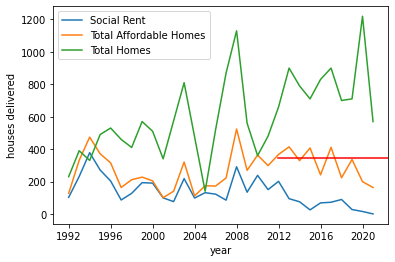

In [73]:
x = dcov['date']
y1 = dcov['SR']
y2 = dcov['AR']
y3 = dcov['DC_Total']
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.axhline(xmin=0.67,y=348,color='r')
plt.xlabel('year')
plt.ylabel('houses delivered')
plt.legend(['Social Rent','Total Affordable Homes','Total Homes'])

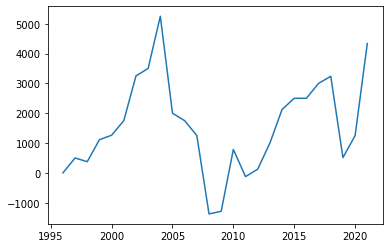

In [101]:
a = dcov4.groupby('year').mean().index
b = dcov4.groupby('year').mean().price_change
plt.plot(a,b)

It looks like as housing prices have risen, housing delivery has fallen. However, there is a lagged effect to housing supply's reaction to housing price changes. We can compare this by lagging house prices by a few periods

In [70]:
a = dcov4.groupby('year').mean().index
b = dcov4.groupby('year').mean().price_change_4

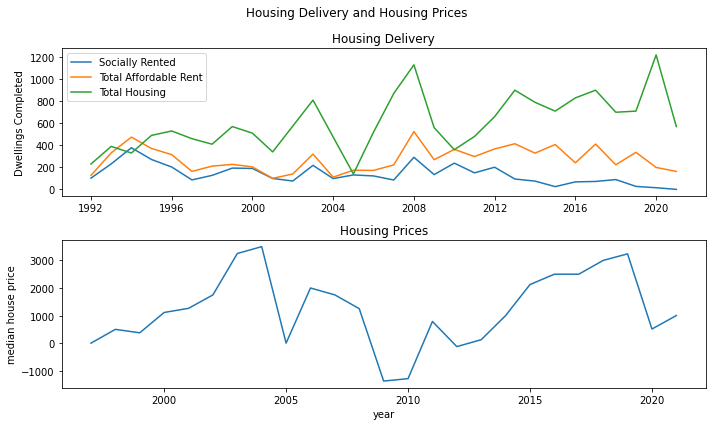

In [132]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,6))
ax[0].plot(x,y1)
ax[0].plot(x,y2)
ax[0].plot(x,y3)
ax[0].set(ylabel='Dwellings Completed',title='Housing Delivery')
ax[0].legend(['Socially Rented','Total Affordable Rent','Total Housing'])
ax[1].plot(a,b)
ax[1].set(ylabel='median house price',xlabel='year',title='Housing Prices')
fig.suptitle('Housing Delivery and Housing Prices')
fig.tight_layout()
plt.show()

In [62]:
from scipy.stats import pearsonr

0.37342090613825524 0.04209325619877667


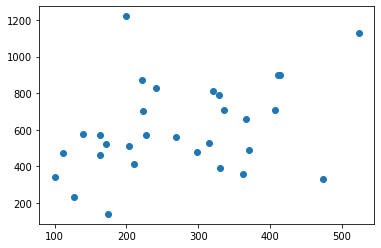

In [168]:
plt.scatter(dcov['AR'],dcov['DC_Total'])
corr, _ = pearsonr(dcov['AR'],dcov['DC_Total'])
print(corr,_)

Calculating correlation matrix between social rent percentage and affordable dwellings

In [140]:
np.cov(dcov['SR_p'],dcov['AR'])

array([[  784.16395987,  -817.32083549],
       [ -817.32083549, 12537.91264368]])

A negative relationship between number of total affordable dwellings completed and percentage socially rented homes delivered

Calculating covariance matrix between affordable homes and total dwellings completed

In [166]:
np.cov(dcov['AR'],dcov['DC_Total'])

array([[12537.91264368, 10417.3908046 ],
       [10417.3908046 , 62071.95402299]])

Text(0.5, 1.0, 'Affordable Delivered as Percentage of Total Dwellings Completed')

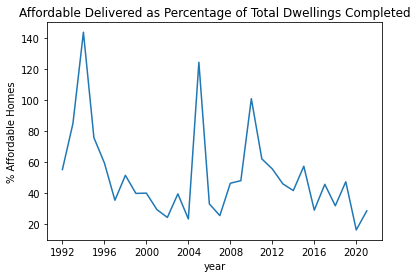

In [30]:
plt.plot(x,dcov['AR_p'])
plt.xlabel('year')
plt.ylabel('% Affordable Homes')
plt.title('Affordable Delivered as Percentage of Total Dwellings Completed')

In [31]:
np.average(dcov.loc[dcov['year']>2008,'AR_p'])

46.947678403282104

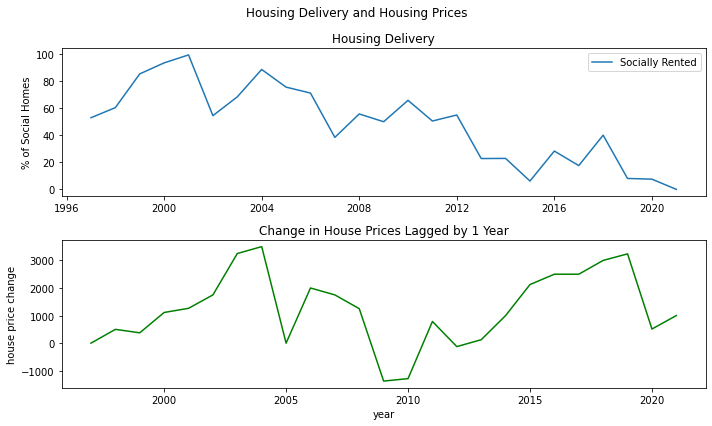

In [152]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,6))
ax[0].plot(x[5:],dcov['SR_p'][5:])
ax[0].set(ylabel='% of Social Homes',title='Housing Delivery')
ax[0].legend(['Socially Rented','Total Affordable Rent','Total Housing'])
ax[1].plot(a[2:],b[2:],color='green')
ax[1].set(ylabel='house price change',xlabel='year',title='Change in House Prices Lagged by 1 Year')
fig.suptitle('Housing Delivery and Housing Prices')
fig.tight_layout()
plt.show()

Checking covariance matrix for % of Socially Rented homes delivered against lagged median house price change

In [144]:
np.cov(dcov['SR_p'][5:],b[2:])

array([[ 8.32327340e+02, -4.86078135e+03],
       [-4.86078135e+03,  1.78559970e+06]])

In [145]:
b

year
1995            NaN
1996            NaN
1997       0.000000
1998     500.000000
1999     375.000000
2000    1112.500000
2001    1262.500000
2002    1750.000000
2003    3250.000000
2004    3500.000000
2005       0.000000
2006    2000.000000
2007    1750.000000
2008    1250.000000
2009   -1375.000000
2010   -1286.250000
2011     786.250000
2012    -125.000000
2013     125.000000
2014    1000.000000
2015    2125.000000
2016    2500.000000
2017    2500.000000
2018    3000.000000
2019    3237.500000
2020     511.875000
2021    1000.833333
Name: price_change_4, dtype: float64

In [40]:
dcov

,LA_code,LA,year,SR,AR,DC_Total,date,SR_p,AR_p
0,E08000026,Coventry,1992,102.0,127.0,230.0,1992-01-01,80.314961,55.217391
1,E08000026,Coventry,1993,231.0,331.0,390.0,1993-01-01,69.788520,84.871795
2,E08000026,Coventry,1994,378.0,474.0,330.0,1994-01-01,79.746835,143.636364
3,E08000026,Coventry,1995,271.0,371.0,490.0,1995-01-01,73.045822,75.714286
4,E08000026,Coventry,1996,203.0,315.0,530.0,1996-01-01,64.444444,59.433962
5,E08000026,Coventry,1997,86.0,163.0,460.0,1997-01-01,52.760736,35.434783
6,E08000026,Coventry,1998,127.0,211.0,410.0,1998-01-01,60.189573,51.463415
7,E08000026,Coventry,1999,193.0,227.0,570.0,1999-01-01,85.022026,39.824561
8,E08000026,Coventry,2000,190.0,204.0,510.0,2000-01-01,93.137255,40.000000
9,E08000026,Coventry,2001,99.0,100.0,340.0,2001-01-01,99.000000,29.411765


In [71]:
c = dcov_pop['date']
d = dcov_pop['pchange']

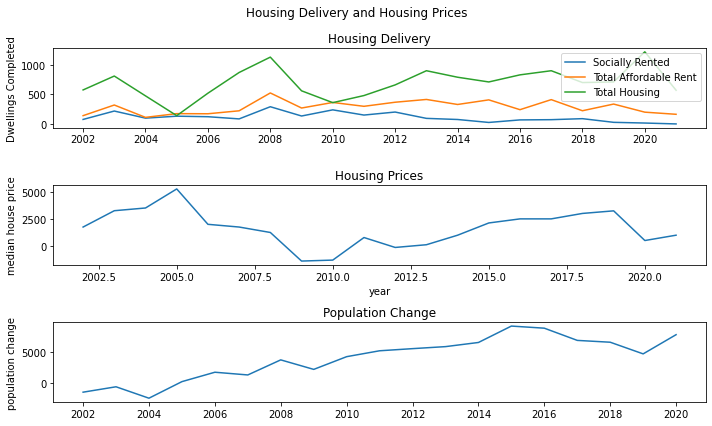

In [76]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(10,6))
ax[0].plot(x[10:],y1[10:])
ax[0].plot(x[10:],y2[10:])
ax[0].plot(x[10:],y3[10:])
ax[0].set(ylabel='Dwellings Completed',title='Housing Delivery')
ax[0].legend(['Socially Rented','Total Affordable Rent','Total Housing'])
ax[1].plot(a[7:],b[7:])
ax[1].set(ylabel='median house price',xlabel='year',title='Housing Prices')
ax[2].plot(c,d)
ax[2].set(ylabel='population change',title='Population Change')
fig.suptitle('Housing Delivery and Housing Prices')
fig.tight_layout()
plt.show()

In [75]:
a

Int64Index([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
            2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
            2017, 2018, 2019, 2020, 2021],
           dtype='int64', name='year')